### Goals
* Use native tensorflow batching; generate augmentations and pair vectors on-demand using as few external libraries as possible.

In [732]:
# hyperparameters
from tensorflow.keras import Model
from tensorflow.keras import layers
cifar_shape = (None,32,32,3)
cifar_shape_x = (1,32,32,3)
nfeatures = 64
nclasses = 10
batchsize = 64

In [731]:
# encoder 
class Encoder(Model):
    def __init__(self, insh=cifar_shape, nb_features=nfeatures):
        super(Encoder, self).__init__()
        self.conv_0 = layers.Conv2D(64, kernel_size=3, strides=1, 
                                     padding='same', activation='relu', input_shape=insh)
        self.batch_norm_0 = layers.BatchNormalization()
        self.conv_1 = layers.Conv2D(32, kernel_size=3, strides=2, 
                                     padding='same', activation='relu')
        self.conv_2 = layers.Conv2D(32, kernel_size=3, strides=1, 
                                     padding='same', activation='relu')
        self.batch_norm_2 = layers.BatchNormalization()
        self.conv_3 = layers.Conv2D(16, kernel_size=3, strides=2, 
                                     padding='same', activation='relu')
        self.batch_norm_3 = layers.BatchNormalization()
        self.flatten = layers.Flatten()
        self.dense_features = layers.Dense(nb_features)
    
    def call(self, xin):
        x = self.conv_0(xin)
        x = self.batch_norm_0(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.batch_norm_2(x)
        x = self.conv_3(x)
        x = self.batch_norm_3(x)
        x = self.flatten(x)
        return self.dense_features(x)

In [730]:
# relation head
class RelationHead(Model):
    def __init__(self, insh=(None,2*nfeatures)):
        super(RelationHead, self).__init__()
        self.dense_0 = layers.Dense(128, activation='relu', input_shape=insh)
        self.dense_1 = layers.Dense(64, activation='relu')
        self.batch_norm_1 = layers.BatchNormalization()
        self.dense_2 = layers.Dense(64, activation='relu')
        self.dense_3 = layers.Dense(32, activation='relu')
        self.dense_4 = layers.Dense(8, activation='relu')
        self.batch_norm_4 = layers.BatchNormalization()
        self.relation = layers.Dense(1, activation='sigmoid')
    
    def call(self, xin):
        x = self.dense_0(xin)
        x = self.dense_1(x)
        x = self.batch_norm_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        x = self.batch_norm_4(x)
        return self.relation(x)

In [756]:
# dataset preparation
from tensorflow.keras.datasets import cifar10
(train, _),(test, __) = cifar10.load_data()
print(train_ds.cardinality())
print(test_ds.cardinality())

tf.Tensor(782, shape=(), dtype=int64)
tf.Tensor(157, shape=(), dtype=int64)


In [768]:
from tensorflow.data import Dataset
train_ds = Dataset.from_tensor_slices(train)
train_ds = train_ds.shuffle(1000,reshuffle_each_iteration=True)
train_ds = train_ds.map(lambda x: x/255)
train_ds = train_ds.batch(batchsize)
test_ds = Dataset.from_tensor_slices(test)
test_ds = test_ds.shuffle(1000,reshuffle_each_iteration=True)
test_ds = test_ds.map(lambda x: x/255)
test_ds = test_ds.batch(batchsize)
print(train_ds.cardinality())
print(test_ds.cardinality())

tf.Tensor(782, shape=(), dtype=int64)
tf.Tensor(157, shape=(), dtype=int64)


In [ ]:
encoder = Encoder()
encoder.build(cifar_shape)
encoder.summary()
relhead = RelationHead()
relhead.build((None,2*nfeatures))
relhead.summary()

In [241]:
# utility functions
import tensorflow as tf
def randint(max=1, min=0):
    return int(min + (tf.random.uniform([1]) * max))

In [770]:
# batch augmentation and pair sampling
from numpy import min as np_min, max as np_max

def channel_norm(im):
    rows,cols,channels = im.shape
    for c in range(channels):
        channel_max = np_max(im[:,:,c])
        channel_min = np_min(im[:,:,c])
        if channel_max > channel_min: # prevents division by zero
            im[:,:,c] = (im[:,:,c] - channel_min) / (channel_max - channel_min)
    return im

# convert single channel images to rgb, return channelwise normalized array
def preprocess(im):
    if len(im.shape) == 2:
        im = tf.grayscale_to_rgb(im)
    return channel_norm(im)

# jitter hue,saturation,value,contrast
def color_jitter(im, h=0.5, s=0.3, v=0.2, c=0.2):
    im = tf.image.random_hue(im,h)
    im = tf.image.random_saturation(im, 1-s, 1+s)
    im = tf.image.random_brightness(im, v)
    return tf.image.random_contrast(im,1-c,1+c)

# convert a proportion p of inputs to 3-channel grayscale
def decolorize(im, p=0.5):
    if tf.random.uniform([1]) < p:
        return tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(im))
    else:
        return im

# crop and resize by bounded random parameters
def crop_resize(im, cl=0.3,ch=1.0,al=3/4,ah=4/3):
    h,w,channels = im.shape
    aspect,crop = tf.random.uniform([2])
    aspect = al + (ah-al)*aspect
    target_h = h * aspect
    target_w = w * (1/aspect)
    crop = cl + (ch-cl)*crop
    crop_h, crop_w = target_h * crop, target_w * crop
    crop_h, crop_w = int(min([crop_h, h-1])), int(min([crop_w, w-1]))
    im = tf.image.random_crop(im, [crop_h,crop_w,channels])
    return tf.image.resize(im, [h, w])

# apply a horizontal flip to some proportion p of inputs
def horizontal_flip(im, p=0.5):
    if tf.random.uniform([1]) < p:
        return tf.image.flip_left_right(im)
    else:
        return im

# apply some intensity of noise between lo and hi to the input image
def apply_noise(im, lo=0.0,hi=0.4):
    pass

def augmentation_sequence(im):
    im = preprocess(im.numpy())
    im = color_jitter(im)
    im = decolorize(im)
    im = crop_resize(im)
    im = horizontal_flip(im)
    #im = apply_noise(im)
    return im.numpy()

# apply all augment functions nb_augment times to each image in a batch
def augment(batch, nb_augment = 16):
    augmented_batch = []
    for i in range(batch.shape[0]):
        x = batch[i]
        augmented_batch.append(x)
        for j in range(1,nb_augment):
            aug_x = augmentation_sequence(x)
            augmented_batch.append(aug_x)
    return tf.stack(augmented_batch, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


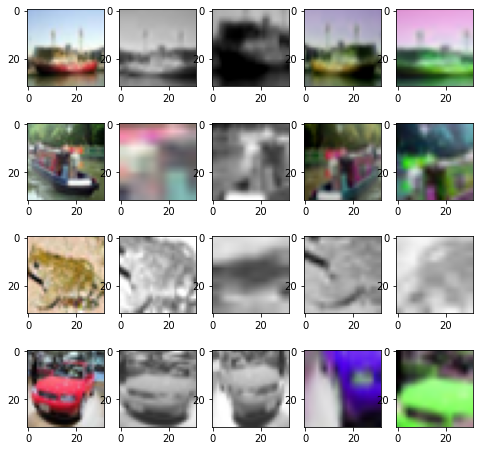

In [728]:
# optional - sanity check on batch augmentation
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
cols = 5
rows = 4
s = randint(train_x.shape[0]-rows-1)
batch = train_x[s:s+rows]/255
augmented_batch = augment(batch, nb_augment=cols)
for i in range(0, cols*rows):
    img = augmented_batch[i]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
plt.show()

In [1]:
# pair two input images
def pair_x(x1,x2,insh=cifar_shape_x):
    if x1.shape != insh:
        x1 = tf.reshape(x1,insh)
    if x2.shape != insh:
        x2 = tf.reshape(x2, insh)
    return tf.concat([x1,x2], 0)

# aggregates two feature vectors together with a linear concatenation
def aggregate(pair):
    ag = tf.concat([pair[0],pair[1]], 0)
    return tf.reshape(ag, (1,2*nfeatures))

# from M*K encoded augmented inputs, sample M*K*K(K-1) positive and negative pairs 
def aggregate_negative(encoded_batch, batch_size):
    pass
def aggregate_positive(encoded_batch, batch_size):
    pass
def aggregate_batch(encoded_batch, batch_size):
    pass

NameError: name 'cifar_shape_x' is not defined

In [753]:
# optional - sanity check on model evaluation
i,j = randint(train_x.shape[0]),randint(train_x.shape[0])

im_pair = pair_x(train_x[i],train_x[j])
print(im_pair.shape)
feature_tuple = encoder(im_pair/255)
pair = aggregate(feature_tuple)
print(pair.shape)
relhead(pair)

(2, 32, 32, 3)
(1, 128)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49844727]], dtype=float32)>